# Timeseries Forecasting w/ Tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Download Bitcoin historical data from GitHub 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-07-30 11:51:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-07-30 11:51:15 (14.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates =['Date'], index_col = ['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.describe()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
count,2787.000000,2787.000000,2787.000000,2787.000000
mean,6529.845141,6513.579485,6710.061683,6302.417386
std,10887.847444,10863.800772,11206.779756,10475.811252
min,108.584830,108.584830,118.675000,83.328330
25%,460.087500,459.400500,469.720995,450.818830
50%,2780.182500,2772.367500,2874.696250,2696.457500
75%,8506.923720,8496.887593,8763.291985,8221.060570
max,63346.789035,63562.673545,64801.787870,62094.632914


In [7]:
df.shape

(2787, 5)

In [8]:
df = df[['Closing Price (USD)']]

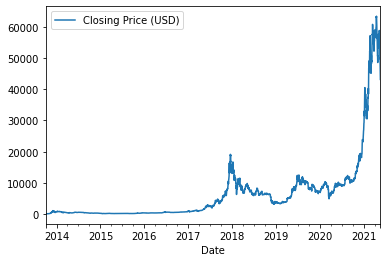

In [9]:
df.plot()

In [10]:
timesteps = df.index.to_numpy()
prices = df['Closing Price (USD)'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

#### Split into Train/Test

In [11]:
train_size = int(0.8*len(df))

In [12]:
X_train, y_train = timesteps[:train_size], prices[:train_size]
X_test, y_test = timesteps[train_size:], prices[train_size:]

## Modelling Experiments

* horizon = number of timesteps to predict into future
* window = number of timesteps from past used to predict horizon

Naive forecast just used previous value to find next value in series

In [13]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [14]:
import tensorflow as tf

In [15]:
def mean_absolute_scaled_error(y_true, y_pred):
  """"""
  # Find MAE
  mae = np.mean(np.abs(y_true - y_pred))
  
  # Find MAE of Naive forecast
  mae_naive = np.mean(np.abs(y_true[1:] - y_pred[:-1]))

  return mae / mae_naive

In [16]:
def evaluate_preds(y_true, y_preds):
  """Return evaluation metrics"""
  #TF sometimes gives errors if data not in float32 type
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_preds, dtype = tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase}

In [17]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_preds=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.69212395,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Create a Windowing Function

In [18]:
# Global Variables for Window and Horizon Size
HORIZON = 1
WINDOW = 7


In [19]:
def get_labelled_windows(x, horizon = HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

Create function to view numpy arrays as windows

In [20]:
def make_windows(x, window_size = WINDOW, horizon_size = HORIZON):
  """Turns 1d array into sequential windowed labels."""
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon_size), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon_size-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon_size)

  return windows, labels


In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon_size=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [22]:
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

#### Turn Windows Into Train & Test Splits

In [23]:
def make_train_test_splits(windows, labels, test_split = 0.2):
  """"""
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [25]:
train_windows

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  121.33866   ,
         120.65533   ,  121.795     ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  120.65533   ,
         121.795     ,  123.033     ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  121.795     ,
         123.033     ,  124.049     ],
       ...,
       [9225.99547934, 9131.41063031, 9197.63234462, ..., 9202.41545055,
        9369.62808116, 9326.59962378],
       [9131.41063031, 9197.63234462, 9290.89660239, ..., 9369.62808116,
        9326.59962378, 9335.75240233],
       [9197.63234462, 9290.89660239, 9202.41545055, ..., 9326.59962378,
        9335.75240233, 9226.48582088]])

#### Create Modelling Checkpoint Callback

In [26]:
import os

In [27]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: Dense Model

In [28]:
from tensorflow.keras import layers

In [29]:
train_windows.shape[1]

7

In [30]:
inputs = layers.Input(shape = (train_windows.shape[1],))
x = layers.Dense(128, activation= 'relu')(inputs)
outputs = layers.Dense(HORIZON, activation = 'linear')(x)

model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [31]:
# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE}

In [32]:
model_1.fit(
    train_windows, 
    train_labels,
    epochs = 100,
    verbose = 1,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_1.name)]
)

Epoch 1/100
18/18 [==============================] - 6s 107ms/step - loss: 3155.5549 - mae: 3155.5549 - val_loss: 7330.6582 - val_mae: 7330.6582
Epoch 2/100
18/18 [==============================] - 1s 67ms/step - loss: 519.6269 - mae: 519.6269 - val_loss: 1499.1045 - val_mae: 1499.1045
Epoch 3/100
18/18 [==============================] - 1s 72ms/step - loss: 239.8375 - mae: 239.8375 - val_loss: 1245.1929 - val_mae: 1245.1929
Epoch 4/100
18/18 [==============================] - 1s 44ms/step - loss: 212.0697 - mae: 212.0697 - val_loss: 1127.3594 - val_mae: 1127.3594
Epoch 5/100
18/18 [==============================] - 1s 62ms/step - loss: 198.9420 - mae: 198.9420 - val_loss: 1085.6436 - val_mae: 1085.6436
Epoch 6/100
18/18 [==============================] - 1s 75ms/step - loss: 191.2193 - mae: 191.2193 - val_loss: 1068.5688 - val_mae: 1068.5688
Epoch 7/100
18/18 [==============================] - 1s 75ms/step - loss: 189.8263 - mae: 189.8263 - val_loss: 1048.8416 - val_mae: 1048.8416
Epo

What did naive model get?

In [33]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.69212395,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [34]:
# Load best performing model

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")

In [35]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.3267 - mae: 568.3267


[568.32666015625, 568.32666015625]

#### Make Forecasts with a Model

In [36]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [37]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8896.028, 8817.538, 9008.146, 8810.954, 8805.625, 8735.955,
        8681.329, 8590.785, 8467.357, 8536.297], dtype=float32)>)

In [38]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_preds=model_1_preds)
model_1_results

{'mae': 568.3268,
 'mape': 2.5580752,
 'mase': 0.6816023,
 'mse': 1172915.2,
 'rmse': 1083.0121}

### Model 2: Using a Larger Window

In [39]:
WINDOW = 30

In [40]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon_size=HORIZON)

In [41]:
full_windows.shape

(2757, 30)

In [42]:
inputs = layers.Input(shape = (train_windows.shape[1],))
x = layers.Dense(128, activation= 'relu')(inputs)
outputs = layers.Dense(HORIZON, activation = 'linear')(x)

model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_dense')

In [43]:
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

In [44]:
model_2.fit(
    train_windows, 
    train_labels,
    epochs = 100,
    verbose = 1,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_2.name)]
)

Epoch 1/100
18/18 [==============================] - 1s 31ms/step - loss: 1159.5413 - mae: 1159.5413 - val_loss: 3652.2996 - val_mae: 3652.2996
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 307.0287 - mae: 307.0287 - val_loss: 993.6460 - val_mae: 993.6460
Epoch 3/100
18/18 [==============================] - 1s 39ms/step - loss: 193.2657 - mae: 193.2657 - val_loss: 975.9026 - val_mae: 975.9026
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 169.1034 - mae: 169.1034 - val_loss: 905.6389 - val_mae: 905.6389
Epoch 5/100
18/18 [==============================] - 0s 27ms/step - loss: 160.4337 - mae: 160.4337 - val_loss: 891.2010 - val_mae: 891.2010
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 158.7278 - mae: 158.7278 - val_loss: 887.3503 - val_mae: 887.3503
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 154.2783 - mae: 154.2783 - val_loss: 893.8588 - val_mae: 893.8588
Epoch 8/100
18/18

In [45]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")

In [46]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.1652 - mae: 568.1652


[568.1652221679688, 568.1652221679688]

In [47]:
model_2_preds = make_preds(model_2, test_windows)

In [48]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_preds=model_2_preds)
model_2_results

{'mae': 568.1652,
 'mape': 2.533061,
 'mase': 0.68756735,
 'mse': 1173656.9,
 'rmse': 1083.3545}

In [49]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

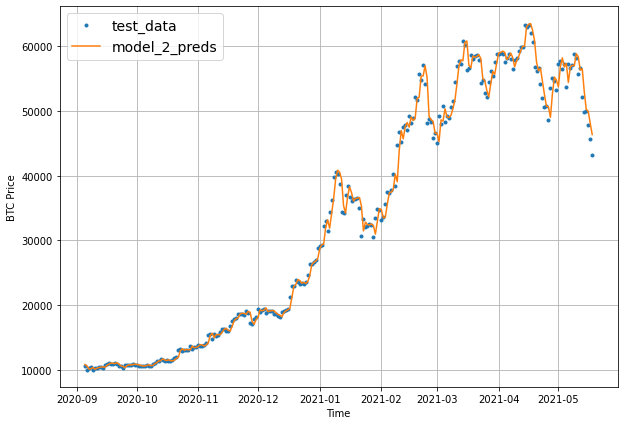

In [50]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

### Model 3: Increased Horizon Size

In [51]:
HORIZON = 7
WINDOW = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW,  horizon_size=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [52]:
inputs = layers.Input(shape = (train_windows.shape[1],))
x = layers.Dense(128, activation= 'relu')(inputs)
outputs = layers.Dense(HORIZON, activation = 'linear')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_dense')

In [53]:
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

In [54]:
model_3.fit(
    train_windows, 
    train_labels,
    epochs = 100,
    verbose = 1,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_3.name)]
)

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 2274.2659 - mae: 2274.2659 - val_loss: 7520.4233 - val_mae: 7520.4233
Epoch 2/100
18/18 [==============================] - 0s 27ms/step - loss: 627.1879 - mae: 627.1879 - val_loss: 1565.9396 - val_mae: 1565.9396
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 257.7080 - mae: 257.7080 - val_loss: 1194.7596 - val_mae: 1194.7596
Epoch 4/100
18/18 [==============================] - 0s 26ms/step - loss: 206.1125 - mae: 206.1125 - val_loss: 1169.4364 - val_mae: 1169.4364
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 195.5492 - mae: 195.5492 - val_loss: 1106.5520 - val_mae: 1106.5520
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 189.9339 - mae: 189.9339 - val_loss: 1111.3431 - val_mae: 1111.3431
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 183.7824 - mae: 183.7824 - val_loss: 1013.1608 - val_mae: 1013.1608
Epoch

In [55]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 589.4684 - mae: 589.4684


[589.4684448242188, 589.4684448242188]

In [56]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 574.9241 - mae: 574.9241


[574.924072265625, 574.924072265625]

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds.shape

TensorShape([556, 7])

In [58]:
def evaluate_preds(y_true, y_preds):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_preds, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": np.array(mase).item()}

In [59]:
model_3_results = evaluate_preds(y_true=test_labels, # remove 1 dimension of test labels
                                 y_preds=model_3_preds)
model_3_results

{'mae': 574.924,
 'mape': 2.5957053,
 'mase': 0.685148298740387,
 'mse': 1193501.4,
 'rmse': 580.59}

In [60]:
tf.squeeze(model_3_preds)

<tf.Tensor: shape=(556, 7), dtype=float32, numpy=
array([[ 8870.474,  8892.036,  8854.31 , ...,  8873.277,  8888.992,
         8897.356],
       [ 8763.009,  8781.861,  8782.54 , ...,  8788.133,  8761.131,
         8743.785],
       [ 8981.473,  9027.664,  9001.376, ...,  8995.853,  8995.079,
         8980.26 ],
       ...,
       [49823.797, 49915.516, 50035.758, ..., 50018.312, 50051.547,
        49730.945],
       [48195.05 , 48532.266, 47888.133, ..., 48112.8  , 48310.633,
        48566.027],
       [45994.062, 45908.117, 45852.03 , ..., 46200.21 , 45954.164,
        45942.1  ]], dtype=float32)>

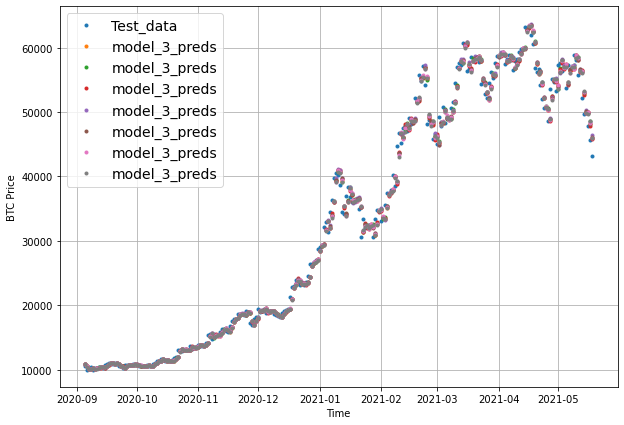

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

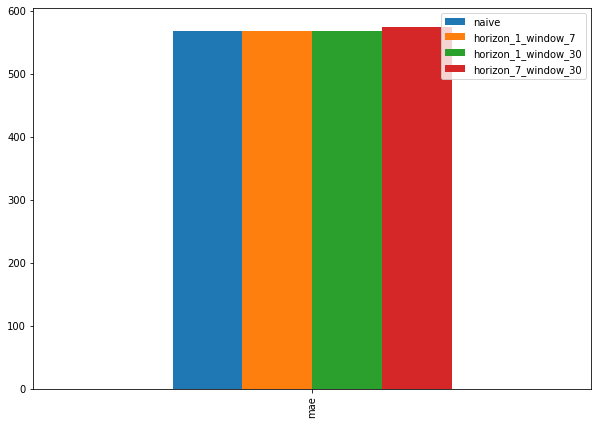

In [62]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [63]:
WINDOW = 7
HORIZON = 1

In [64]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW,  horizon_size=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [65]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [66]:
train_windows[0].shape

(7,)

In [67]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [68]:
inputs = layers.Input(shape = (train_windows.shape[1],))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Conv1D(filters = 128, kernel_size = 5, padding = 'causal', activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_4 = tf.keras.Model(inputs, outputs, name = "model_4_conv1D")

In [69]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 64)             8256      
                                                                 
 dense_7 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [70]:
HORIZON

1

In [71]:
model_4.compile(
    loss = 'mae',
    optimizer = 'Adam'
)

In [72]:
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128, 
    epochs=100,
    verbose=1,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 11s 95ms/step - loss: 2173.4680 - val_loss: 1692.5255
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 342.9774 - val_loss: 1912.7188
Epoch 3/100
18/18 [==============================] - 1s 46ms/step - loss: 225.7666 - val_loss: 1340.1877
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 196.5154 - val_loss: 1126.0089
Epoch 5/100
18/18 [==============================] - 1s 48ms/step - loss: 189.4192 - val_loss: 1051.5731
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 188.6091 - val_loss: 1106.5981
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 182.5564 - val_loss: 1051.7003
Epoch 8/100
18/18 [==============================] - 1s 48ms/step - loss: 179.6440 - val_loss: 995.6262
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 176.2017 - val_loss: 1005.8715
Epoch 10/100
18/18 [==============================] - 1s 4

In [73]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 566.8350


566.8349609375

In [74]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8804.624 , 8736.129 , 8996.263 , 8720.945 , 8708.02  , 8717.727 ,
       8628.466 , 8495.6045, 8418.811 , 8494.518 ], dtype=float32)>

In [75]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_preds=model_4_preds)
model_4_results

{'mae': 566.83496,
 'mape': 2.5552204,
 'mase': 0.6815395951271057,
 'mse': 1158784.6,
 'rmse': 1076.4686}

### Model 5: RNN (LSTM)

In [76]:
inputs = layers.Input(shape = WINDOW)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 0))(inputs)
#x = layers.LSTM(128, return_sequences = True, activation = 'relu')(x)
x = layers.LSTM(128, activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_lstm')

In [77]:
model_5.compile(
    loss = 'mae',
    optimizer = 'Adam'
)

In [78]:
model_5.fit(
    train_windows,
    train_labels,
    batch_size=128, 
    epochs=100,
    verbose=1,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2801854.2500INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 5s 209ms/step - loss: 2741448.0000 - val_loss: 30195514.0000
Epoch 2/100
18/18 [==============================] - 2s 97ms/step - loss: 2296969.7500 - val_loss: 61459200.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 8274372.5000INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 192ms/step - loss: 8095889.5000 - val_loss: 10154040.0000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 1819494.1250INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 187ms/step - loss: 1780458.2500 - val_loss: 116102.9453
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 98629.8203 INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 186ms/step - loss: 96623.1094 - val_loss: 49427.3984
Epoch 6/100
18/18 [==============================] - 2s 98ms/step - loss: 62684.5039 - val_loss: 60872.2031
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 19927.8164INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 4s 208ms/step - loss: 19773.4941 - val_loss: 39784.5742
Epoch 8/100
18/18 [==============================] - 2s 97ms/step - loss: 254641.2656 - val_loss: 376627.6250
Epoch 9/100
18/18 [==============================] - 2s 100ms/step - loss: 91348.1562 - val_loss: 50654.1875
Epoch 10/100
18/18 [==============================] - 2s 98ms/step - loss: 35037.2383 - val_loss: 152257.5938
Epoch 11/100
18/18 [==============================] - 2s 97ms/step - loss: 8648.7695 - val_loss: 59754.2227
Epoch 12/100
18/18 [==============================] - 2s 97ms/step - loss: 8225.0498 - val_loss: 142721.8281
Epoch 13/100
18/18 [==============================] - 2s 100ms/step - loss: 13080.0859 - val_loss: 155432.6562
Epoch 14/100
18/18 [==============================] - 2s 103ms/step - loss: 21605.1875 - val_loss: 58004.2578
Epoch 15/100
18/18 [==============================] - 2s 100ms/step - loss: 8588.8018 - val_loss: 53766.0859
Epoch 16/100
18/18 [=======

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 188ms/step - loss: 6047.1519 - val_loss: 32347.1289
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 8507.7510INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 187ms/step - loss: 8487.7529 - val_loss: 14650.0742
Epoch 27/100
18/18 [==============================] - 2s 97ms/step - loss: 6158.2139 - val_loss: 31672.0566
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 6514.8320INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 3s 191ms/step - loss: 6442.7578 - val_loss: 12579.4658
Epoch 29/100
18/18 [==============================] - 2s 99ms/step - loss: 9316.9033 - val_loss: 85316.3516
Epoch 30/100
18/18 [==============================] - 2s 102ms/step - loss: 48452.2656 - val_loss: 196987.5156
Epoch 31/100
18/18 [==============================] - 2s 101ms/step - loss: 28417.1641 - val_loss: 86063.1094
Epoch 32/100
18/18 [==============================] - 2s 98ms/step - loss: 22924.7227 - val_loss: 83175.4062
Epoch 33/100
18/18 [==============================] - 2s 98ms/step - loss: 16492.9238 - val_loss: 191287.4688
Epoch 34/100
18/18 [==============================] - 2s 98ms/step - loss: 18123.8672 - val_loss: 93356.0156
Epoch 35/100
18/18 [==============================] - 2s 99ms/step - loss: 17430.5371 - val_loss: 57171.7188
Epoch 36/100
18/18 [==============================] - 2s 97ms/step - loss: 14255.3008 - val_loss: 116736.7734
Epoch 37/100
18/18 [========

## Multivariate Dataset

Add bitcoin halving events to dataset

In [79]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block_reward column
bitcoin_prices_block = df.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Closing Price (USD),block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


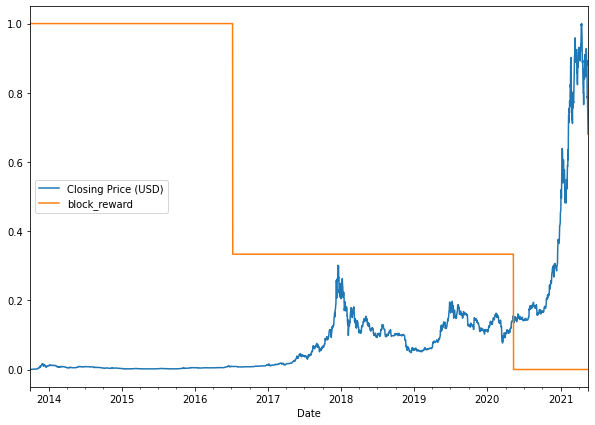

In [82]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Closing Price (USD)", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));


In [83]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Closing Price (USD)+{i+1}"] = bitcoin_prices_windowed["Closing Price (USD)"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Closing Price (USD),block_reward,Closing Price (USD)+1,Closing Price (USD)+2,Closing Price (USD)+3,Closing Price (USD)+4,Closing Price (USD)+5,Closing Price (USD)+6,Closing Price (USD)+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [84]:
X = bitcoin_prices_windowed.dropna().drop("Closing Price (USD)", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Closing Price (USD)"].astype(np.float32)
X.head()

,block_reward,Closing Price (USD)+1,Closing Price (USD)+2,Closing Price (USD)+3,Closing Price (USD)+4,Closing Price (USD)+5,Closing Price (USD)+6,Closing Price (USD)+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [85]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense MV

In [86]:
inputs = layers.Input(shape = X_train.shape[1])
x = layers.Dense(128, activation = 'relu')(inputs)
x = layers.Dense(64, activation = 'relu')(x)

outputs = layers.Dense(HORIZON)(x)
model_6 = tf.keras.Model(inputs, outputs, name = 'model_6_D_MV')

In [87]:
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [88]:
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_D_MV/assets


In [89]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_D_MV")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 573.5144


573.514404296875

In [90]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8806.057, 8741.835, 9019.647, 8713.089, 8694.655, 8732.156,
       8644.237, 8475.2  , 8433.643, 8503.071], dtype=float32)>

In [91]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_preds=model_6_preds)
model_6_results

{'mae': 573.5144,
 'mape': 2.5923,
 'mase': 0.6915621161460876,
 'mse': 1174112.0,
 'rmse': 1083.5645}

### Model 7: N-BEATS

https://arxiv.org/pdf/1905.10437.pdf

##### Building the N_BEATS Block Layer

Have to build layer as doesnt exist in TF

In [92]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(self.n_neurons, activation = 'relu') for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation = 'linear')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    
    return backcast, forecast

In [93]:
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW, 
    theta_size=WINDOW+HORIZON, # backcast + forecast 
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4
)

In [94]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW)+1, axis = 0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [95]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

In [96]:
backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.00726092, -0.1497536 , -0.573451  , -0.13121086, -0.2619954 ,
         -0.2739389 ,  0.6048526 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.23921908]], dtype=float32)>)

### Preparing Data W/ tf.data

In [97]:
df.head()

,Closing Price (USD)
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [98]:
# Add windowed columns
bitcoin_prices_nbeats = df.copy()
for i in range(WINDOW):
  bitcoin_prices_nbeats[f"Closing Price (USD)+{i+1}"] = bitcoin_prices_nbeats["Closing Price (USD)"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Closing Price (USD),Closing Price (USD)+1,Closing Price (USD)+2,Closing Price (USD)+3,Closing Price (USD)+4,Closing Price (USD)+5,Closing Price (USD)+6,Closing Price (USD)+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [99]:
X = bitcoin_prices_nbeats.dropna().drop("Closing Price (USD)", axis=1)
y = bitcoin_prices_nbeats.dropna()["Closing Price (USD)"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [100]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Setting up hyperparameters

In [101]:
N_EPOCHS = 5000 # sometimes called "Iterations" 
N_NEURONS = 512 # sometimes called "Width" 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW* HORIZON # called "Lookback"
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

Need 2 layers for residual parts of N-BEATS model (add and subtract).
N-BEATS uses double residual stacking to help train its deep architecture

In [ ]:
%%time

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape = INPUT_SIZE, name = 'stack_input')

residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS - 1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name = f'subtract_{i}')
  forecast = layers.add([residuals, forecast])

# Put the model together using functional API
model_7 = tf.keras.Model(stack_input, forecast, name = 'n_beats')

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Plotting the N-beats model

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

### Ensemble

In [ ]:
def get_ensemble_models(horizon = HORIZON,
                       train_data = train_dataset,
                       test_data = test_dataset,
                       num_iter = 10,
                       num_epochs = 1000,
                       loss_functions = ['mae', 'mape', 'mse']):
  """"""
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_functions:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      ensemble_models.append(model)

  return ensemble_models

In [105]:
%%time
ensemble_models = get_ensemble_models()

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 848: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 948: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 791: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 891: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 325: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 425: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 764: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 864: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing 

In [106]:
!nvidia-smi

Sat Jul 30 12:11:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1836MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [107]:
def make_ensemble_preds(ensemble_models, data):
  """"""
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [108]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)

In [109]:
ensemble_preds

<tf.Tensor: shape=(30, 556), dtype=float32, numpy=
array([[ 8751.544 ,  8735.9795,  9085.024 , ..., 49520.8   , 49301.004 ,
        45770.715 ],
       [ 8822.295 ,  8811.975 ,  9047.192 , ..., 50151.52  , 48771.832 ,
        45942.57  ],
       [ 8726.603 ,  8739.168 ,  9016.647 , ..., 49958.207 , 48899.035 ,
        46142.746 ],
       ...,
       [ 8762.109 ,  8765.547 ,  9106.561 , ..., 49949.92  , 48417.137 ,
        46176.094 ],
       [ 8786.689 ,  8795.546 ,  9028.825 , ..., 50102.293 , 48109.49  ,
        46389.36  ],
       [ 8828.495 ,  8748.662 ,  9037.831 , ..., 49640.85  , 48776.066 ,
        45854.6   ]], dtype=float32)>

In [110]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds) 

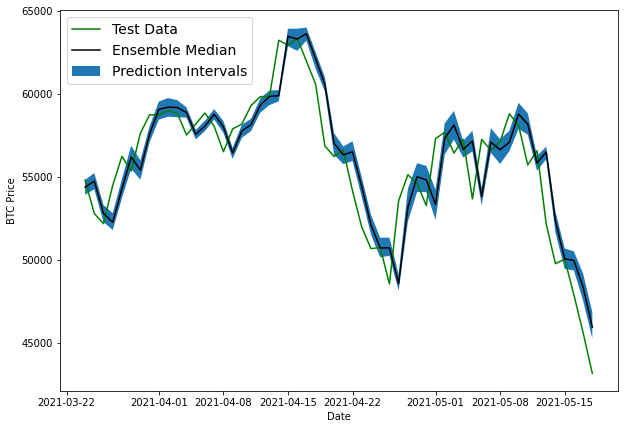

In [111]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

* Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

    * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
    * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

    * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
    * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

### Model 9: Train on Full Historical Dataset

In [112]:
bitcoin_prices_windowed.head()

,Closing Price (USD),block_reward,Closing Price (USD)+1,Closing Price (USD)+2,Closing Price (USD)+3,Closing Price (USD)+4,Closing Price (USD)+5,Closing Price (USD)+6,Closing Price (USD)+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [113]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Closing Price (USD)", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Closing Price (USD)"].to_numpy()

In [114]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [115]:
# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [116]:
INTO_FUTURE = 14

In [117]:
def make_future_forecast(values, model, into_future, window_size) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW:]
  
  return future_forecast

In [118]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55476.3828125

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55476.3828125 ] -> Prediction: 52923.25

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55476.3828125  52923.25      ] -> Prediction: 48790.33203125

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55476.3828125  52923.25       48790.33203125] -> Prediction: 47690.16796875

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55476.3828125
 52923.25       48790.33203125 47690.16796875] -> Prediction: 47220.7734375

Predicting on: 
 [45604.61575361 43144.47129086 55476.3828125  52923.25
 48790.33203125 47690.16796875 47220.7734375 ] -> Prediction: 46069.1875

Predicting on: 
 [43144.47129086 55476.3828125  52923.25       48790.33203125
 4769

In [119]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [120]:
last_timestep = df.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [121]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [122]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps.shape, future_forecast.shape

((15,), (15,))

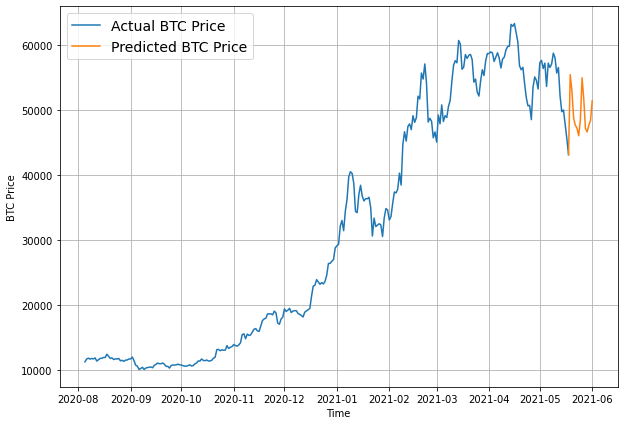

In [124]:
plt.figure(figsize=(10, 7))
plot_time_series(df.index, prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Turkey Problem

In [125]:
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [128]:
btc_timesteps_turkey = np.array(df.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

Change 1 value

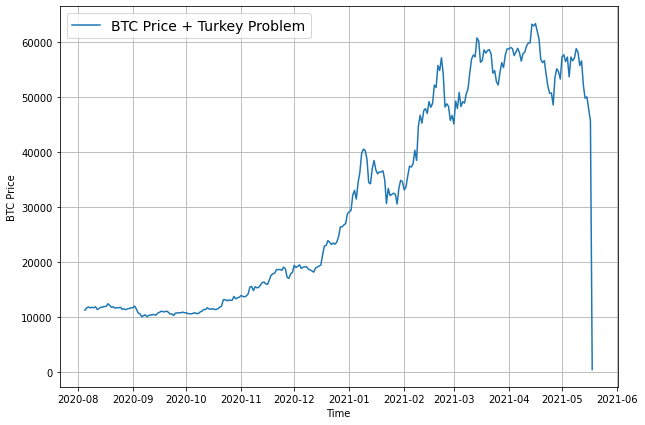

In [129]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [132]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW, horizon_size=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [133]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


In [134]:
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 640.2097


640.209716796875